In [442]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from skimage import io, color, filters, measure
import pickle as pkl
import yaml
import scanpy as sc

import sys
sys.path.insert(0, "/home/icb/alessandro.palma/environment/IMPA/IMPA/experiments/measure_metrics")
from compute_metrics import *

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from itertools import combinations
from pathlib import Path

# Utility functions 

In [399]:
def initialize_model(yaml_config, dest_dir):
    args_rdkit = OmegaConf.create(yaml_config)
    dataloader_rdkit = CellDataLoader(args_rdkit)
    solver_rdkit = IMPAmodule(args_rdkit, dest_dir, dataloader_rdkit)
    return solver_rdkit

class Args:
    def __init__(self, dictionary):
        self.__dict__ = dictionary

    def __getattr__(self, key):
        if key in self.__dict__:
            return self.__dict__[key]
        else:
            raise AttributeError(f"'DictToObject' object has no attribute '{key}'")

    def __call__(self, key):
        return self.__getattr__(key)


def t2np(t, batch_dim=False):
    return ((t.permute(0, 2, 3, 1) + 1) / 2).clamp(0, 1).cpu().numpy()


def plot_n_images(images, n_to_plot, channel=None, size=((1.5, 1.5))):
    for i, img in enumerate(images):
        plt.figure(figsize=size)
        if channel == None:
            plt.imshow(img)
        else:
            plt.imshow(img[:,:,channel],"grey")
        plt.axis("off")
        plt.grid("off")
        plt.show()
        if i == n_to_plot:
            break

def transform_by_emb(solver, dataloader, y, n_average, args):
    """
    Transform images in a dataloader using a solver for a specific drug ID.

    Parameters:
        solver: The solver object used for transformation.
        dataloader: The dataloader containing images to be transformed.
        n_average (int): Number of times to average random noise vectors.
        drug_id (str): The ID of the drug for transformation.
        args: Arguments object containing additional parameters.

    Returns:
        tuple: A tuple containing two NumPy arrays representing controls and transformed images.
    """
    controls = []
    transformed = []
    y = y.unsqueeze(0)
    with torch.no_grad():
        for batch in tqdm(dataloader.train_dataloader()):
            X_ctr = batch["X"][0]
            z = torch.randn(X_ctr.shape[0], n_average, args.z_dimension).cuda().mean(1)
            # z = torch.randn(X_ctr.shape[0], n_average, args.z_dimension).cuda().quantile(0.75,0)
            
            # Perturbation ID 
            y_emb = y.repeat((z.shape[0], 1)).cuda()
            y_emb = torch.cat([y_emb, z], dim=1)
            y_emb = solver.nets.mapping_network(y_emb) 
            
            _, X_generated = solver.nets.generator(X_ctr, y_emb)
            transformed.append(t2np(X_generated.detach().cpu()))
            controls.append(t2np(X_ctr.detach().cpu()))
            break
    return np.concatenate(controls, axis=0), np.concatenate(transformed, axis=0)

# Import models

In [400]:
bbbbc021_embeddings = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/embeddings/csv/emb_fp_all.csv", index_col=0)

bbbc021_index = pd.read_csv("/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/data/bbbc021_unannotated/processed/bbbc021_unannotated_large/metadata/bbbc021_unannotated_large.csv",
                           index_col=0)

Get ood drugs 

In [401]:
ood_drugs = ["leupeptin", 
                 "bohemine", 
                 "MG-132", 
                 "colchicine", 
                 "cytochalasin D",
                 "deoxymannojirimycin", 
                 "epothilone B", 
                 "docetaxel", 
                 "etoposide",
                 "quercetin",
                 "mevinolin/lovastatin",
                 "SB-203580",
                 "vinblastine",
                 "AZ258"]

In [402]:
ood_drug_embeddings = bbbbc021_embeddings.loc[ood_drugs]

In [403]:
path_to_configs = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/config_hydra/config")

with open(path_to_configs / 'REBUTTAL_bbbc021_large_all.yaml', 'r') as IMPA_bbbc021:
    # Load YAML data using safe_load() from the file
    yaml_IMPA_bbbc021 = yaml.safe_load(IMPA_bbbc021)

dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240822_0a488a26-5d65-43ba-863d-d7ada8f7086b_bbbc021_unannotated_large"

args = OmegaConf.create(yaml_IMPA_bbbc021)
dataloader = CellDataLoader(args)
IMPA_bbbc021 = initialize_model(yaml_IMPA_bbbc021, dest_dir)

IMPA_bbbc021._load_checkpoint(200)

Number of parameters in generator: 24318595
Number of parameters in style_encoder: 16164480
Number of parameters in discriminator: 14339732
Number of parameters in mapping_network: 66624
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
IMPAmodule(
  (embedding_matrix): Embedding(84, 1024)
  (generator): DataParallel(
    (module): Generator(
      (from_rgb): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (encode): ModuleList(
        (0): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Fals

# Check embeddings

In [404]:
learnt_embs = []
drug_labs = []

In [405]:
for emb in bbbbc021_embeddings.index:
    learnt_embs.append(torch.tensor(bbbbc021_embeddings.loc[emb]))
    drug_labs.append(emb)

In [406]:
learnt_embs = torch.stack(learnt_embs, dim=0).cuda()

In [407]:
with torch.no_grad():
    z = torch.randn(1, 100, args.z_dimension).cuda().mean(1)
    z = z.repeat((learnt_embs.shape[0], 1)).cuda()
    y_emb = torch.cat([learnt_embs, z], dim=1)
    y_emb = IMPA_bbbc021.nets.mapping_network(y_emb).cpu()

In [408]:
obs = pd.DataFrame({"Drug name": drug_labs, 
       "State": ["Unseen" if drug in ood_drugs else "Seen" for drug in drug_labs]
      })

In [409]:
adata = sc.AnnData(X=y_emb.numpy(), 
                  obs=obs)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [410]:
sc.tl.pca(adata)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


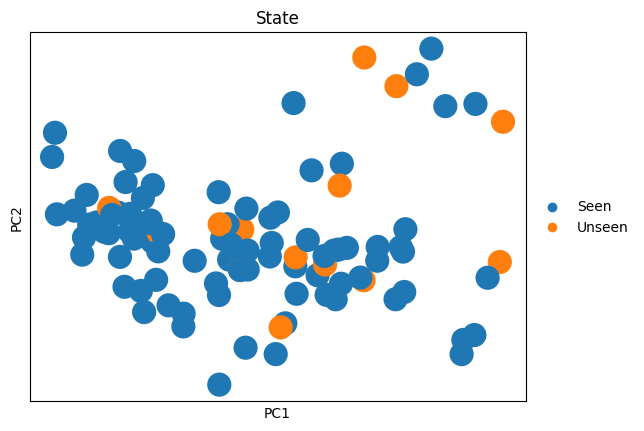

In [411]:
sc.pl.pca(adata, color="State")

In [412]:
sc.pp.neighbors(adata)

In [413]:
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


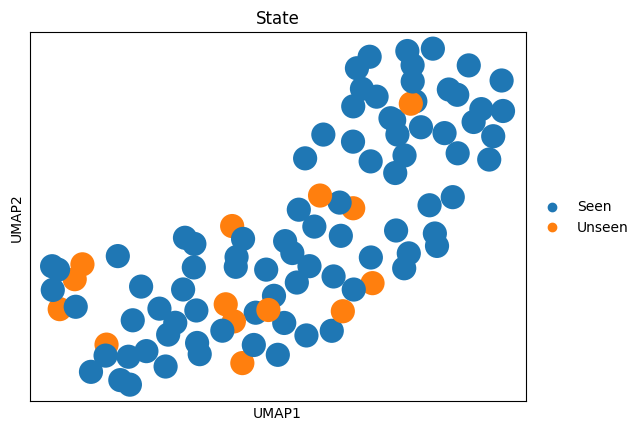

In [414]:
sc.pl.umap(adata, color="State")

## Annotate the plot

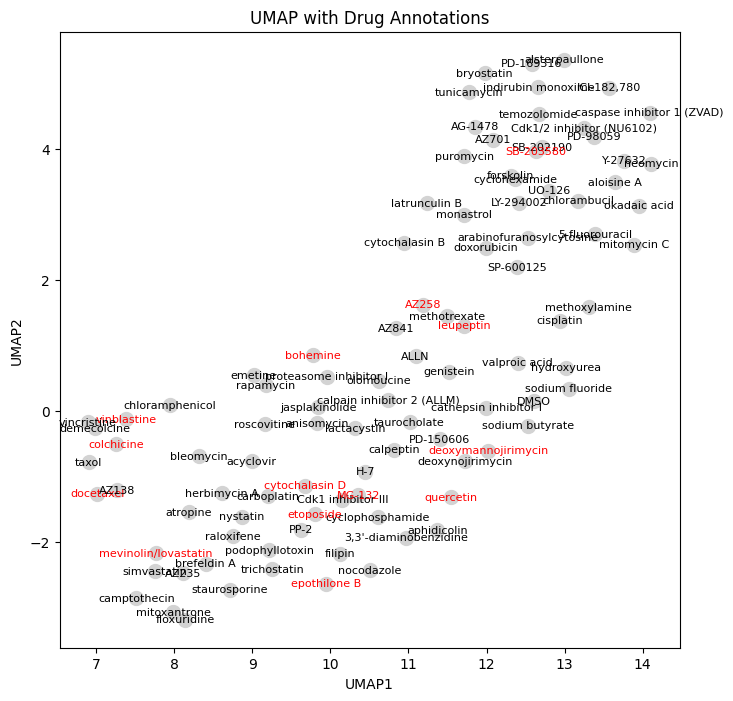

In [415]:
umap_coords = adata.obsm['X_umap']

# Annotation names (drug names) are stored in a specific column of adata.obs
annotation_names = adata.obs['Drug name']  # Replace 'drug_names' with your column name

# Create the UMAP plot
plt.figure(figsize=(8, 8))
plt.scatter(umap_coords[:, 0], umap_coords[:, 1], s=100, c='lightgray')  # Plot the UMAP points

# Annotate the UMAP with drug names
for i, name in enumerate(annotation_names):
    col = "black" if name not in ood_drugs else "red"
    plt.text(umap_coords[i, 0], umap_coords[i, 1], name, fontsize=8, ha='center', va='center', color=col)

# Optionally, you can add axis labels and a title
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP with Drug Annotations')

# Show the plot
plt.show()

## Get one real image per drug 

In [416]:
folder = Path("/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/data/bbbc021_unannotated/processed/bbbc021_unannotated_large")

In [417]:
leavout_plates = {
         "DMSO": ["Week1_22401"],
         "PD-150606": ["Week9_39301"],
         "cathepsin inhibitor I":["Week9_39221"],
         "colchicine": ["Week1_22401","Week1_22123"],
         "cytochalasin B": ["Week1_22161","Week1_22123"],
         "doxorubicin": ["Week1_22361"],
         "epothilone B": ["Week1_22361"],
         "latrunculin B": ["Week1_22381","Week1_22401"], 
         "nocodazole": ["Week1_22123","Week1_22381"]}

In [418]:
idxs = []
drug2image = {}
drug2week = {}

for drug in np.unique(bbbc021_index.CPD_NAME):
    bbbc021_index_loc = bbbc021_index.loc[bbbc021_index.CPD_NAME==drug]
    batch  = np.array(bbbc021_index_loc.BATCH)
    if drug in leavout_plates:
        bbbc021_index_loc = bbbc021_index.loc[~bbbc021_index.BATCH.isin(leavout_plates[drug])]
    # Choose random obs 
    m = 0
    v = 0
    while m < 20 or v < 200:
        choice = np.random.choice(list(bbbc021_index_loc.index))
        filename = bbbc021_index.loc[choice].SAMPLE_KEY
        filename_split = filename.split("_")
        file = np.load(folder / filename_split[0] / filename_split[1] / ('_'.join(filename_split[2:])+".npy"))
        m = file.mean()
        v = file.var()
    
    drug2image[drug] = file
    drug2week[drug] = bbbc021_index_loc.loc[choice].BATCH
    
# bbbc021_index_no_dup = bbbc021_index.loc[idxs]
# bbbc021_index_no_dup = bbbc021_index.loc[bbbc021_index.CPD_NAME=="taxol"]
# file2drug = list(zip(bbbc021_index_no_dup.SAMPLE_KEY, bbbc021_index_no_dup.ANNOT))
# drug2week = dict(zip(bbbc021_index_no_dup.ANNOT, bbbc021_index_no_dup.BATCH))

In [419]:
# for filename, drug in file2drug:
#     filename_split = filename.split("_")
#     file = np.load(folder / filename_split[0] / filename_split[1] / ('_'.join(filename_split[2:])+".npy"))
#     drug2image[drug] = file

3,3'-diaminobenzidine
Week8_38241
78.69923909505208
3119.2431000069614


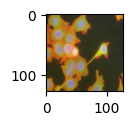

5-fluorouracil
Week4_27481
97.80507405598958
2645.6487917995287


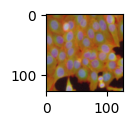

AG-1478
Week9_39222
102.74277750651042
2765.934263834937


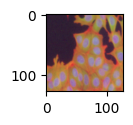

ALLN
Week2_24141
53.967081705729164
1921.755060591632


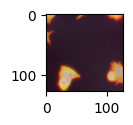

AZ138
Week10_40115
74.97920735677083
4484.867324827446


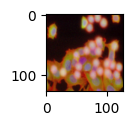

AZ235
Week9_39206
53.376688639322914
2344.8628867562447


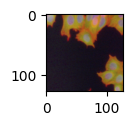

AZ258
Week4_27861
72.81422932942708
2826.6451564129034


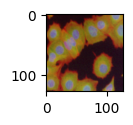

AZ701
Week5_28961
99.22391764322917
2413.3495190921753


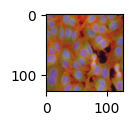

AZ841
Week3_25421
68.4813232421875
2781.7377289781966


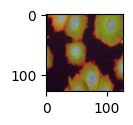

Cdk1 inhibitor III
Week8_38221
52.347330729166664
1682.3142978880144


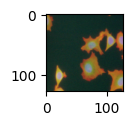

Cdk1/2 inhibitor (NU6102)
Week10_40119
81.79158528645833
2434.772603346242


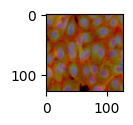

DMSO
Week10_40115
80.88850911458333
2673.768941852781


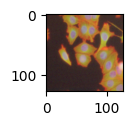

H-7
Week9_39221
93.94781494140625
2503.132835801691


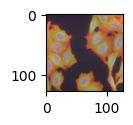

ICI-182,780
Week5_29341
83.09259033203125
2330.569938586404


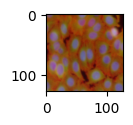

LY-294002
Week5_28921
101.53847249348958
2598.650171885474


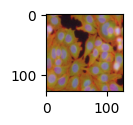

MG-132
Week2_24401
47.919270833333336
741.3128187391493


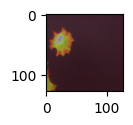

PD-150606
Week8_38221
23.585103352864582
1879.0263267552684


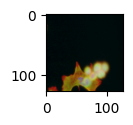

PD-169316
Week7_34681
96.95241292317708
1993.345249304755


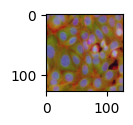

PD-98059
Week3_25721
109.37247721354167
2322.6322161290377


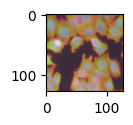

PP-2
Week8_38342
108.69053141276042
2481.4541356062723


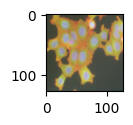

SB-202190
Week5_28901
54.14599609375
2538.0199449062347


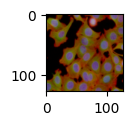

SB-203580
Week5_29301
40.511393229166664
2077.309277746413


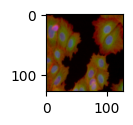

SP-600125
Week6_31641
99.79903157552083
1860.0409105204874


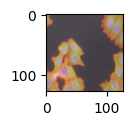

UO-126
Week3_25441
77.68894449869792
3647.6224217212034


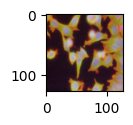

Y-27632
Week3_25681
98.72861735026042
2054.6285609300767


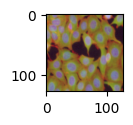

acyclovir
Week6_32121
61.313578287760414
3240.0950890676017


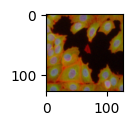

aloisine A
Week5_29301
72.17618815104167
2229.954431368245


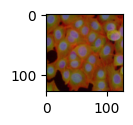

alsterpaullone
Week7_34681
97.9952392578125
2303.4746680905423


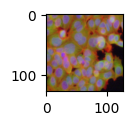

anisomycin
Week4_27521
41.2442626953125
3763.2896602799497


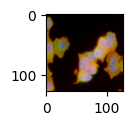

aphidicolin
Week1_22161
105.74058024088542
4056.8379137909246


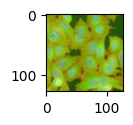

arabinofuranosylcytosine
Week7_34341
73.94500732421875
2710.9366934162877


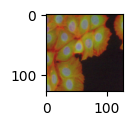

atropine
Week6_32161
74.05192057291667
2556.2897033426493


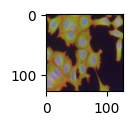

bleomycin
Week6_31641
78.76841227213542
2676.8888923521667


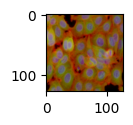

bohemine
Week8_38341
58.354695638020836
2949.101079025202


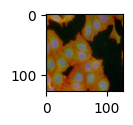

brefeldin A
Week2_24361
116.26973470052083
2080.5819469673766


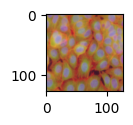

bryostatin
Week7_34681
47.726155598958336
2967.970866991414


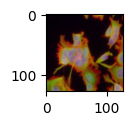

calpain inhibitor 2 (ALLM)
Week6_32061
45.045654296875
2323.637523432573


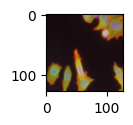

calpeptin
Week8_38342
77.87913004557292
3406.9865094319816


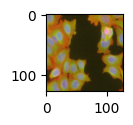

camptothecin
Week8_38203
38.092366536458336
1550.2046031885675


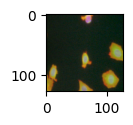

carboplatin
Week9_39283
34.799825032552086
847.68720455923


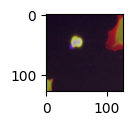

caspase inhibitor 1 (ZVAD)
Week4_27801
104.54777018229167
2671.6158006919754


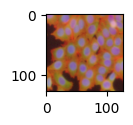

cathepsin inhibitor I
Week2_24141
94.67637125651042
2967.49294103144


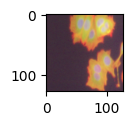

chlorambucil
Week3_25721
87.99755859375
3086.626336812973


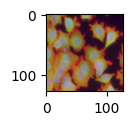

chloramphenicol
Week7_34681
89.19779459635417
2017.7818815294238


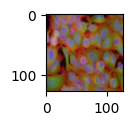

cisplatin
Week3_25701
79.91839599609375
2562.9715919258692


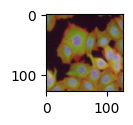

colchicine
Week1_22161
103.72145589192708
3617.3005259728266


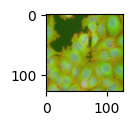

cyclohexamide
Week4_27861
53.708943684895836
2103.0089548412293


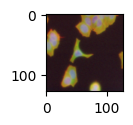

cyclophosphamide
Week8_38342
80.66853841145833
2628.5566371215714


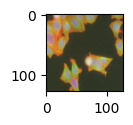

cytochalasin B
Week1_22361
101.1607666015625
3422.3346277326345


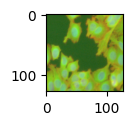

cytochalasin D
Week2_24121
35.701741536458336
1858.5286362899672


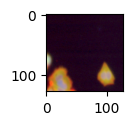

demecolcine
Week3_25721
29.770975748697918
2660.838925659243


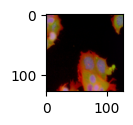

deoxymannojirimycin
Week7_34681
49.845499674479164
2140.8268376572264


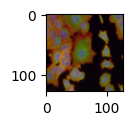

deoxynojirimycin
Week9_39283
80.60788981119792
2482.5401989813486


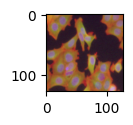

docetaxel
Week7_34341
30.586161295572918
3220.593121478541


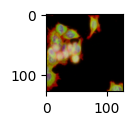

doxorubicin
Week6_31641
112.17681884765625
2203.8229627969363


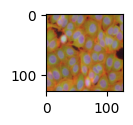

emetine
Week3_25701
31.654825846354168
2563.8497675640715


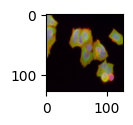

epothilone B
Week10_40119
116.13736979166667
2032.3258154127334


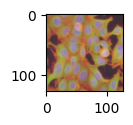

etoposide
Week3_25441
108.88936360677083
1609.9374259296392


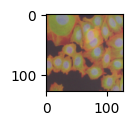

filipin
Week8_38342
42.269510904947914
2136.4176185921665


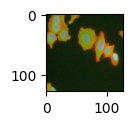

floxuridine
Week9_39282
81.77858479817708
2271.1999377107454


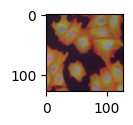

forskolin
Week7_34641
98.97001139322917
1781.9248819334637


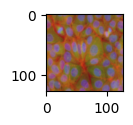

genistein
Week2_24141
110.61574300130208
3362.336782594108


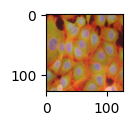

herbimycin A
Week2_24401
35.06390380859375
2315.577398236841


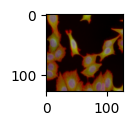

hydroxyurea
Week6_31681
64.06732177734375
2666.5626267952225


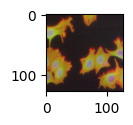

indirubin monoxime
Week4_27542
79.95113118489583
2779.346488792036


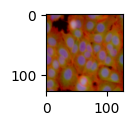

jasplakinolide
Week2_24361
60.204264322916664
3178.629500044717


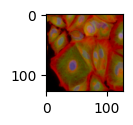

lactacystin
Week6_31681
49.245096842447914
2842.575608690166


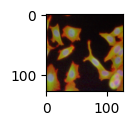

latrunculin B
Week4_27542
53.738382975260414
3790.440650770648


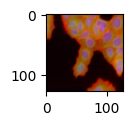

leupeptin
Week8_38241
64.18312581380208
975.296685476684


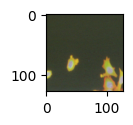

methotrexate
Week2_24141
89.0030517578125
3305.8292143195868


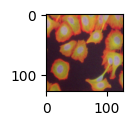

methoxylamine
Week5_29301
95.43644205729167
2065.2141407264603


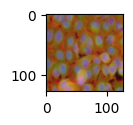

mevinolin/lovastatin
Week9_39222
40.05621337890625
1509.81859705473


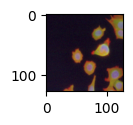

mitomycin C
Week4_27801
99.32790120442708
2923.321415533208


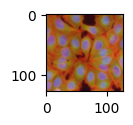

mitoxantrone
Week9_39301
70.09425862630208
2567.2415832475654


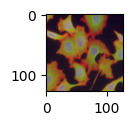

monastrol
Week10_40119
31.34527587890625
1103.3303084932268


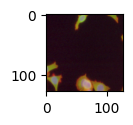

neomycin
Week4_27821
114.17523193359375
2595.8626246613762


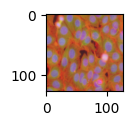

nocodazole
Week3_25421
60.937886555989586
3392.118680168771


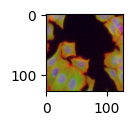

nystatin
Week8_38221
184.59842936197916
277.8366251372629


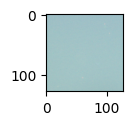

okadaic acid
Week4_27861
85.26198323567708
2931.7066536839634


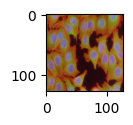

olomoucine
Week4_27542
78.22542317708333
3337.199754052692


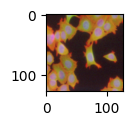

podophyllotoxin
Week6_32061
30.82220458984375
2057.8878834210336


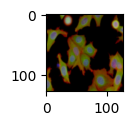

proteasome inhibitor I
Week7_34641
65.91164143880208
2501.947372614924


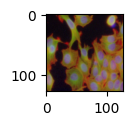

puromycin
Week7_34341
86.88014729817708
3072.3246856228347


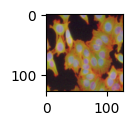

quercetin
Week8_38241
52.126444498697914
1815.6500477588015


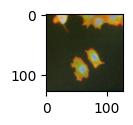

raloxifene
Week5_28921
61.82647705078125
2407.2570601962507


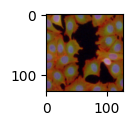

rapamycin
Week2_24121
95.81398518880208
1952.2650200720461


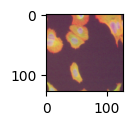

roscovitine
Week2_24361
91.05098470052083
2769.994877773854


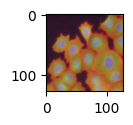

simvastatin
Week9_39283
66.99477132161458
2834.9842459356623


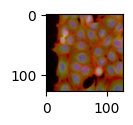

sodium butyrate
Week6_32161
66.71797688802083
1531.1547158939973


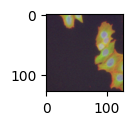

sodium fluoride
Week6_31641
95.7059326171875
3059.972850546241


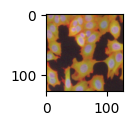

staurosporine
Week3_25421
38.3419189453125
2874.4909609009824


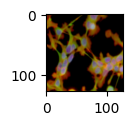

taurocholate
Week6_32161
23.122314453125
1524.9434538880985


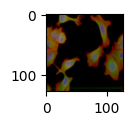

taxol
Week3_25721
52.3233642578125
3620.2596526791654


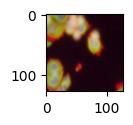

temozolomide
Week10_40119
112.02113850911458
2083.8422655657764


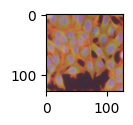

trichostatin
Week6_31681
26.630147298177082
2176.3459767198397


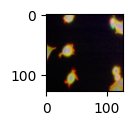

tunicamycin
Week4_27481
91.48211669921875
1999.04769451047


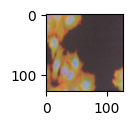

valproic acid
Week7_34661
67.24346923828125
2818.757149325063


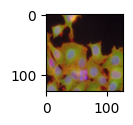

vinblastine
Week2_24161
22.003641764322918
2028.2288889185422


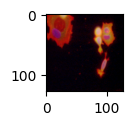

vincristine
Week3_25461
46.122172037760414
3053.697781512721


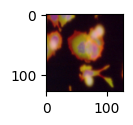

In [420]:
for drug in drug2image:
    print(drug)
    print(drug2week[drug])
    print(drug2image[drug].mean())
    print(drug2image[drug].var())
    plt.figure(figsize=(1,1))
    plt.imshow(drug2image[drug])
    plt.show()

## Transform images 

In [421]:
drugs = {}
controls = {}

for drug in ood_drugs:
    emb_drug = torch.Tensor(ood_drug_embeddings.loc[drug])
    control, transformed = transform_by_emb(IMPA_bbbc021, dataloader, emb_drug, 1, args)
    drugs[drug] = transformed
    controls[drug] = control

  0%|          | 0/593 [00:03<?, ?it/s]


leupeptin
Transformed


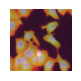

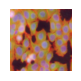

Real


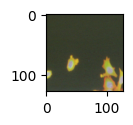

bohemine
Transformed


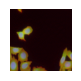

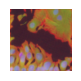

Real


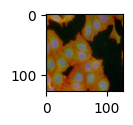

MG-132
Transformed


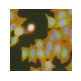

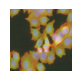

Real


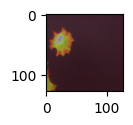

colchicine
Transformed


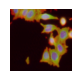

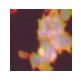

Real


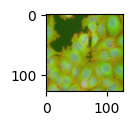

cytochalasin D
Transformed


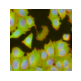

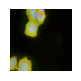

Real


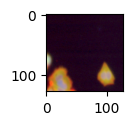

deoxymannojirimycin
Transformed


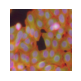

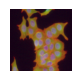

Real


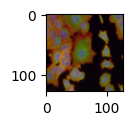

epothilone B
Transformed


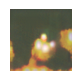

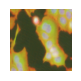

Real


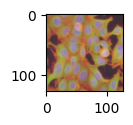

docetaxel
Transformed


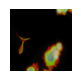

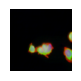

Real


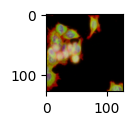

etoposide
Transformed


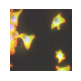

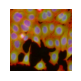

Real


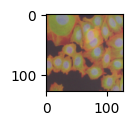

quercetin
Transformed


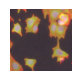

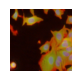

Real


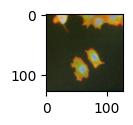

mevinolin/lovastatin
Transformed


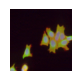

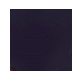

Real


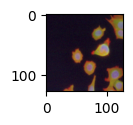

SB-203580
Transformed


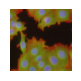

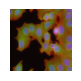

Real


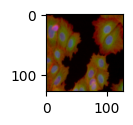

vinblastine
Transformed


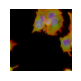

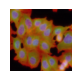

Real


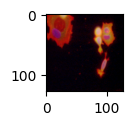

AZ258
Transformed


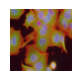

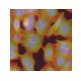

Real


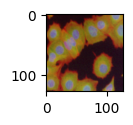

In [422]:
for drug in drugs:
    print(drug)
    # plot_n_images(controls[drug], 5, [0,1,2], (0.8,0.8))
    print("Transformed")
    plot_n_images(drugs[drug], 1, [0,1,2], (0.8,0.8))
    print("Real")
    plt.figure(figsize=(1,1))
    plt.imshow(drug2image[drug])
    plt.show()

## Check phenotypes in the UMAP

In [423]:
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [424]:
exclude = ["aphidicolin"]

In [425]:
def annotate_images(ax, x, y, img):
    imagebox = OffsetImage(img, zoom=0.15)  # Adjust zoom as necessary
    ab = AnnotationBbox(imagebox, (x, y), frameon=False)
    ax.add_artist(ab)

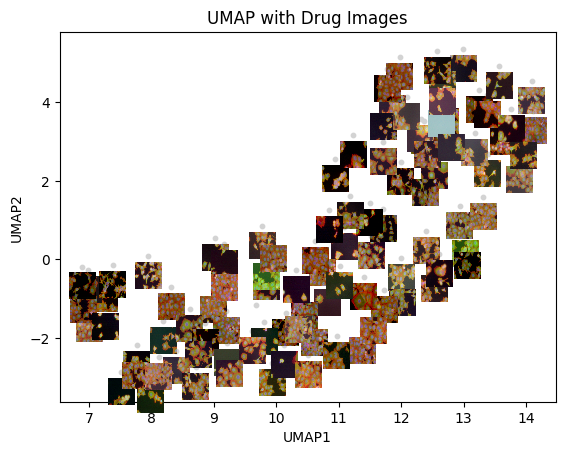

In [426]:
# Create the UMAP plot
fig, ax = plt.subplots()
ax.scatter(umap_coords[:, 0], umap_coords[:, 1], s=10, c='lightgray')  # Plot the UMAP points

# Annotate UMAP with images
for i, drug in enumerate(drug2image.keys()):
    if drug not in exclude:
        annotate_images(ax, umap_coords[i, 0], umap_coords[i, 1] - 0.5, drug2image[drug])
    # plt.imshow(drug2image[drug], extent=(umap_coords[i, 0] - 0.5, umap_coords[i, 0] + 0.5, 
    #                         umap_coords[i, 1] - 0.5, umap_coords[i, 1] + 0.5), aspect='auto')

# Optionally, you can add axis labels and a title
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP with Drug Images')

# Show the plot
plt.show()

## Do the plots from before 

In [428]:
def compute_tanimoto_distance_from_df(df):
    """
    Computes Tanimoto distance between all pairs of SMILES strings in a DataFrame.

    Parameters:
    - df: DataFrame with SMILES strings in a column.

    Returns:
    - distances_df: DataFrame containing Tanimoto distances between all pairs of SMILES strings.
    """
    # Convert SMILES strings to RDKit Mol objects
    mols = [Chem.MolFromSmiles(smiles) for smiles in df['SMILES']]

    # Calculate fingerprints for each molecule
    fps = [AllChem.GetMorganFingerprint(mol, 2) for mol in mols]

    # Compute Tanimoto distance between all pairs of fingerprints
    distances = []

    similarity_df = pd.DataFrame(index=df.index, columns=df.index)
    for i, j in combinations(range(len(df)), 2):
        tanimoto_similarity = DataStructs.TanimotoSimilarity(fps[i], fps[j])
        similarity_df.at[df.index[i], df.index[j]] = tanimoto_similarity
        similarity_df.at[df.index[j], df.index[i]] = tanimoto_similarity
    return similarity_df.fillna(1.0)

In [433]:
metadata_unique = bbbc021_index[["CPD_NAME", "SMILES"]]
metadata_unique = metadata_unique.drop_duplicates(subset="CPD_NAME").set_index("CPD_NAME", drop=True)

tanimoto_distance_matrix = compute_tanimoto_distance_from_df(metadata_unique)

tanimoto_distance_matrix.loc[ood_drugs]
mat_tani_second_highest_val = tanimoto_distance_matrix.apply(lambda row: row.nlargest(2).iloc[-1], axis=1)
mat_tani_second_highest_cpd = tanimoto_distance_matrix.apply(lambda row: row.nlargest(2).index[-1], axis=1)

mat_tani_second_highest_ood = mat_tani_second_highest_val.loc[ood_drugs]

In [441]:
mat_tani_second_highest_ood.sort_values()

CPD_NAME
epothilone B            0.251852
quercetin               0.487179
cytochalasin D          0.542636
etoposide               0.569231
MG-132                  0.623762
docetaxel               0.726316
bohemine                0.738095
mevinolin/lovastatin    0.780220
leupeptin               0.785714
SB-203580               0.797619
colchicine              0.845238
AZ258                   0.903509
vinblastine             0.913793
deoxymannojirimycin     1.000000
dtype: float64